In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import FuncFormatter
import masw_functions as mf
from scipy.ndimage import gaussian_filter
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [2]:
# Load dispersin images and header
fileheader="dispersion_header.pkl"
header = pd.read_pickle(fileheader)
filedimage="dispersion_images.pkl"
dimage = pd.read_pickle(filedimage)

In [3]:
# Header editing
header['MPx'] = header['MPx'] .apply(lambda x: float(x.values))
header['MPy'] = header['MPy'] .apply(lambda x: float(x.values))
header['MPazimuth'] = header['MPazimuth'] .apply(lambda x: float(x.values))
header['MPxn'] = header['MPx'] - header['MPx'].min()
header['MPyn'] = header['MPy'] - header['MPy'].min()


In [4]:
##
vmin, vmax = 600,4000
fmin, fmax = 1,5
freq = np.linspace(fmin,fmax,80)
p=np.linspace(0, 1/vmin, 101)
phavel=[]
mderror=[]
midpoint=[]

In [5]:
## Select bin
dmx = 500.
dmy = 500.
for mx in np.arange(header['MPxn'].min()+dmx,header['MPxn'].max()-dmx,dmx) :
    for my in np.arange(header['MPyn'].min()+dmy,header['MPyn'].max()-dmy,dmy) :  
        try :  
            print(f'mx: {mx}    my:{my}')
            binx = (header['MPxn']>mx) & (header['MPxn']<mx+dmx)
            biny = (header['MPyn']>my) & (header['MPyn']<my+dmy)
            headerbin = header[binx & biny]
            idbin = header[binx & biny].index

            ## Stacking an smoothing of Dispersion Image
            dimageb = np.mean(np.stack([dimage[i] for i in idbin], axis=0), axis=0)
            dimagebi = gaussian_filter(dimageb**2, sigma=10.0)
            dimagebin = dimagebi/np.max(dimagebi,axis=0, keepdims=True)

            ## # Dispersion curve extraction
            pr = p[np.argmax(dimagebin, axis=0)]
            freq = np.linspace(fmin,fmax,dimagebin.shape[1])
            phavel.append(1/pr)
            midpoint.append((mx+dmx/2,my+dmy/2))
        except Exception as e:
            print(f"An error occurred: {e}")
            mderror.append([mx,my])


mx: 500.0    my:500.0
mx: 500.0    my:1000.0
mx: 500.0    my:1500.0
mx: 500.0    my:2000.0
mx: 500.0    my:2500.0
mx: 500.0    my:3000.0
mx: 500.0    my:3500.0
mx: 500.0    my:4000.0
mx: 500.0    my:4500.0
mx: 500.0    my:5000.0
mx: 500.0    my:5500.0
mx: 500.0    my:6000.0
mx: 500.0    my:6500.0
mx: 500.0    my:7000.0
mx: 500.0    my:7500.0
mx: 500.0    my:8000.0
mx: 500.0    my:8500.0
mx: 500.0    my:9000.0
mx: 500.0    my:9500.0
mx: 500.0    my:10000.0
mx: 500.0    my:10500.0
mx: 500.0    my:11000.0
mx: 500.0    my:11500.0
mx: 1000.0    my:500.0
mx: 1000.0    my:1000.0
mx: 1000.0    my:1500.0
mx: 1000.0    my:2000.0
mx: 1000.0    my:2500.0
mx: 1000.0    my:3000.0
mx: 1000.0    my:3500.0
mx: 1000.0    my:4000.0
mx: 1000.0    my:4500.0
mx: 1000.0    my:5000.0
mx: 1000.0    my:5500.0
mx: 1000.0    my:6000.0
mx: 1000.0    my:6500.0
mx: 1000.0    my:7000.0
mx: 1000.0    my:7500.0
mx: 1000.0    my:8000.0
mx: 1000.0    my:8500.0
mx: 1000.0    my:9000.0
mx: 1000.0    my:9500.0
mx: 1000.0   

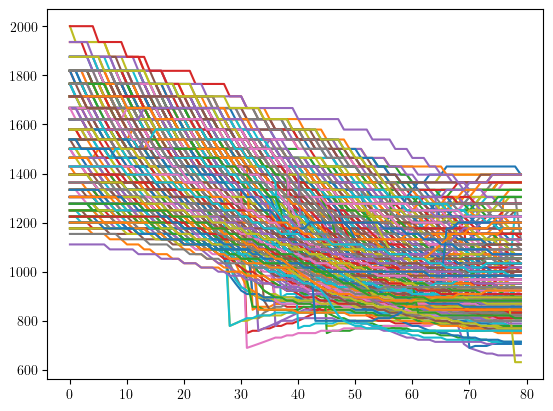

In [6]:
plt.figure()
for id in range(len(phavel)):  #  range(len(phavel)):
    if phavel[id][-1] < 1400 and np.all(phavel[id]>600) :
        plt.plot(phavel[id])
plt.show()

In [18]:
len(phavel)

598

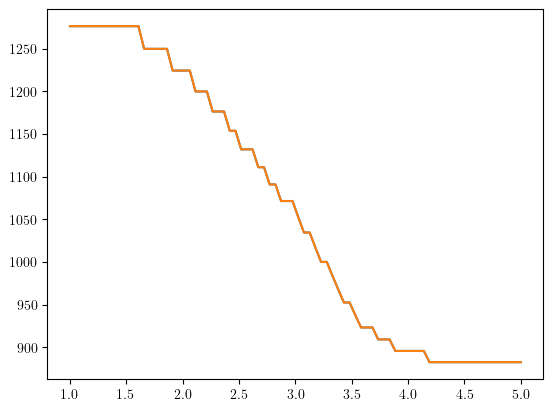

In [27]:
id = 597
plt.plot(freq,phavel[id])
Xobs = mf.decreasing(phavel[id], freq)
plt.plot(Xobs[:,0],Xobs[:,1])

In [28]:
Nh = 10
rps=2.5
alpha=100
n_iter=10
dh=10.0
(vsi,hi,zi)=mf.InitialModel(Xobs,Nh)


Text(0, 0.5, 'Depth (m)')

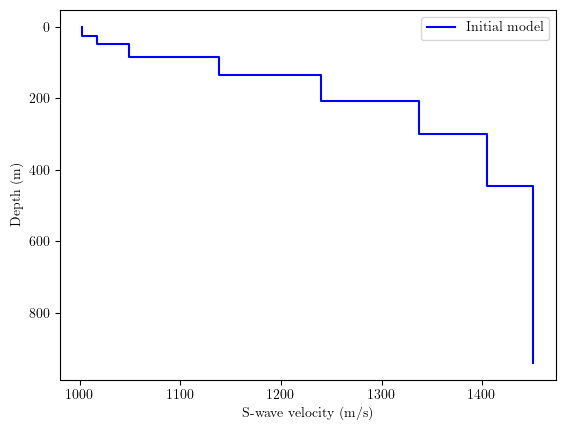

In [29]:
plt.figure()
plt.step(np.append(vsi,vsi[-1]),zi,label='Initial model',color='blue')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("S-wave velocity (m/s)")
plt.ylabel("Depth (m)")

In [30]:
rhoi=2*np.ones(np.size(vsi))
hi=np.round(hi/dh)*dh
(vsf,vpf,error)=mf.sw_inversion(Xobs[:,1],Xobs[:,0],vsi,rhoi,hi,rps,n_iter,alpha,dh)

  0%|          | 0/10 [00:00<?, ?it/s]

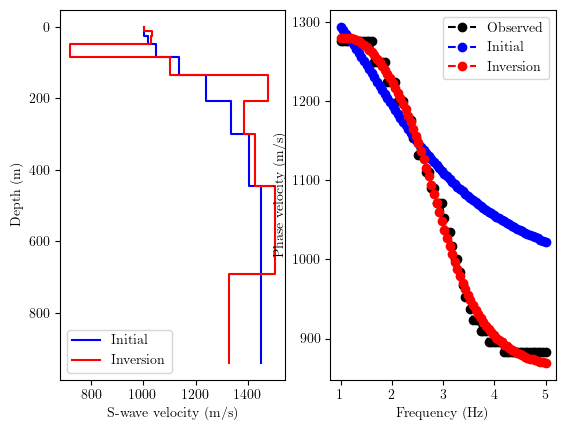

In [31]:
fig, axs = plt.subplots(1,2)
axs[0].step(np.append(vsi,vsi[-1]),zi, color='blue', label='Initial')
axs[0].step(np.append(vsf,vsf[-1]),zi, color='red', label='Inversion')
axs[0].set(xlabel='S-wave velocity (m/s)', ylabel='Depth (m)')
axs[0].legend()
axs[0].invert_yaxis()

cRia=mf.forward_dispersion(vsi,rps*vsi,rhoi,hi,Xobs[:,0])
cRfa=mf.forward_dispersion(vsf,rps*vsf,rhoi,hi,Xobs[:,0])
axs[1].plot(Xobs[:,0], Xobs[:,1], 'o--', color='black', label='Observed')
axs[1].plot(Xobs[:,0], cRia, 'o--', color='blue', label='Initial')
axs[1].plot(Xobs[:,0], cRfa, 'o--', color='red', label='Inversion')
axs[1].set(xlabel='Frequency (Hz)', ylabel='Phase velocity (m/s)')
axs[1].legend()

In [32]:
## inversion
Nh = 10
rps=2.5
alpha=100
n_iter=10
dh=10.0
invmodel = []
errorinv = []
for id in range(len(phavel)):  #  range(len(phavel)):
    if phavel[id][-1] < 1400 and np.all(phavel[id]>600) :
            mx, my = midpoint[id]
            print(f'mx: {mx}    my:{my}')
            Xobs = mf.decreasing(phavel[id], freq)
            try:
                (vsi,hi,zi)=mf.InitialModel(Xobs,Nh)
                rhoi=2*np.ones(np.size(vsi))
                hi=np.round(hi/dh)*dh
                (vsf,vpf,error)=mf.sw_inversion(Xobs[:,1],Xobs[:,0],vsi,rhoi,hi,rps,n_iter,alpha,dh)
                invmodel.append([vsf, hi, mx, my])
            except Exception as e:
                errorinv.append(id)
                print(f"An error occurred: {e}")

mx: 750.0    my:750.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 750.0    my:1250.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 750.0    my:1750.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 750.0    my:2250.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 750.0    my:2750.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 750.0    my:3750.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 750.0    my:4250.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 750.0    my:4750.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 750.0    my:5250.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 750.0    my:5750.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 750.0    my:6250.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 750.0    my:6750.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 750.0    my:7250.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 750.0    my:7750.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 750.0    my:8250.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 750.0    my:8750.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 750.0    my:9250.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 750.0    my:9750.0


  0%|          | 0/10 [00:00<?, ?it/s]

/home/ivan/Documents/SW_Inversion_3D_Data/Niscota_Example/masw_functions.py:89: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  cR[i] = np.abs(fsolve(dispersion, x0=c0,  args=(vs,vp,rho,h,f[i]), xtol=1e-10))
/home/ivan/Documents/SW_Inversion_3D_Data/Niscota_Example/masw_functions.py:134: RuntimeWarning: invalid value encountered in sqrt
  gamma=np.sqrt(k**2-(w/vp[-1])**2)
/home/ivan/Documents/SW_Inversion_3D_Data/Niscota_Example/masw_functions.py:135: RuntimeWarning: invalid value encountered in sqrt
  v=np.sqrt(k**2-(w/vs[-1])**2)


An error occurred: SVD did not converge
mx: 750.0    my:10250.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 750.0    my:10750.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 750.0    my:11250.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 750.0    my:11750.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 1250.0    my:750.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 1250.0    my:1250.0


  0%|          | 0/10 [00:00<?, ?it/s]

An error occurred: SVD did not converge
mx: 1250.0    my:1750.0


  0%|          | 0/10 [00:00<?, ?it/s]

An error occurred: SVD did not converge
mx: 1250.0    my:2750.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 1250.0    my:3250.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 1250.0    my:3750.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 1250.0    my:4250.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 1250.0    my:4750.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 1250.0    my:5250.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 1250.0    my:5750.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 1250.0    my:6250.0


  0%|          | 0/10 [00:00<?, ?it/s]

mx: 1250.0    my:6750.0


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 